In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Time series

### Plot original data

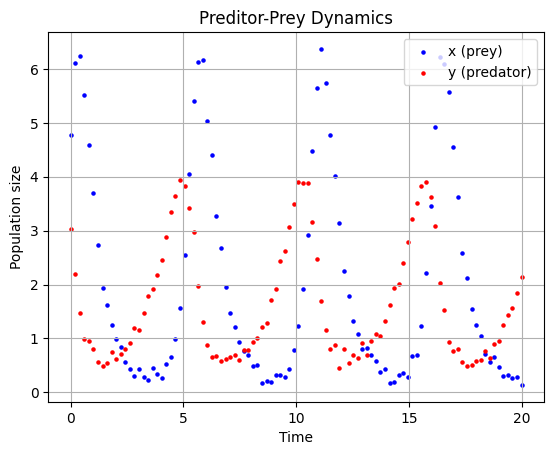

In [2]:
# import data from csv
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = df["t"]
x = df["x"]
y = df["y"]

# split data for two y axises
plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()
plt.scatter(t, x, color = 'b', s = 5, label = 'x (prey)')
plt.scatter(t, y, color = 'r', s = 5, label = 'y (predator)')
plt.legend()
t_data = []
for i in range(0, 21, 5):
    t_data.append(i)
plt.xticks(t_data)

# show plot
plt.show()

### Functions

In [3]:
# Lotka-Volterra equations

def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

In [9]:
# Objective functions

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t_data)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

### Fit data with loss function res 

In [41]:
def minimise_loss_function_res(df):
    params0 = np.array([0.5, 0.8, 0.3, 0.5])
    output_minimise = minimize(loss_function_res, params0, args=(df))
    fitted_parameters = output_minimise.x
    loss = output_minimise.fun
    return output_minimise


def plot_lotka(df, fitted_parameters, extra_df=None):
    t = np.array(df['t'], dtype=float)
    x = np.array(df['x'], dtype=float)
    y = np.array(df['y'], dtype=float)
    alpha_fit, beta_fit, delta_fit, gamma_fit = fitted_parameters
    y0 = [x[0], y[0]]
    t = np.linspace(t[0], t[-1], num=len(t))
    output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

    plt.title("Preditor-Prey Dynamics")
    plt.ylabel("Population size")
    plt.xlabel("Time")
    plt.grid()

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["x"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()

    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')
    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["y"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()

## Remove random points

In [49]:
np.random.seed(3)

def remove_random_rows(df, percentage):
    '''
    Percentage as decimal number.
    '''
    # Number of rows to remove
    remove_n = int(len(df) * percentage)

    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    return df.drop(drop_indices)

# remove n% of rows in original dataframe
df_subset_25 = remove_random_rows(df, 0.25)
df_subset_50 = remove_random_rows(df, 0.50)
df_subset_75 = remove_random_rows(df, 0.75)

# concatenate subset 25% removed and 75% removed
df_subset_25_75 = pd.concat([df_subset_25, df_subset_75], ignore_index=True).sort_values(by='t')


In [34]:
minimised_original = minimise_loss_function_res(df)
print(minimised_original)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 456.0418711258587
        x: [ 4.762e+00  1.867e+00  1.294e-01  2.844e-01]
      nit: 33
      jac: [ 1.053e+02  1.124e+03  4.376e+02  2.445e+03]
 hess_inv: [[ 1.083e-01  5.678e-03 -6.562e-03 -8.037e-03]
            [ 5.678e-03  2.982e-04 -3.440e-04 -4.212e-04]
            [-6.562e-03 -3.440e-04  3.975e-04  4.867e-04]
            [-8.037e-03 -4.212e-04  4.867e-04  5.967e-04]]
     nfev: 595
     njev: 117


In [27]:
minimised_25 = minimise_loss_function_res(df_subset_25)
print(minimised_25)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 606.131763634931
        x: [-7.427e-01 -8.514e-02 -7.397e-02 -1.447e-02]
      nit: 11
      jac: [-1.544e+02  3.415e+02  5.620e+02 -1.061e+03]
 hess_inv: [[ 2.937e-02 -7.128e-03  7.157e-03 -9.634e-04]
            [-7.128e-03  2.381e-03 -1.837e-03  3.205e-04]
            [ 7.157e-03 -1.837e-03  1.841e-03 -2.025e-04]
            [-9.634e-04  3.205e-04 -2.025e-04  7.594e-05]]
     nfev: 186
     njev: 36


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

In [28]:
minimised_50 = minimise_loss_function_res(df_subset_50)
print(minimised_50)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 296.56157078862424
        x: [ 1.229e+01  5.747e+00  1.857e-02  1.868e-02]
      nit: 72
      jac: [ 1.528e+00  2.049e+00  7.699e+01 -1.417e+02]
 hess_inv: [[ 1.146e-03 -2.173e-05 -1.454e-05 -9.103e-06]
            [-2.173e-05  2.652e-05  1.070e-06  5.764e-07]
            [-1.454e-05  1.070e-06  6.129e-06  2.734e-06]
            [-9.103e-06  5.764e-07  2.734e-06  1.249e-06]]
     nfev: 676
     njev: 133


In [29]:
minimised_75 = minimise_loss_function_res(df_subset_75)
print(minimised_75)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 129.7551599414594
        x: [ 3.563e-02  5.921e-02 -2.871e-02 -4.801e-02]
      nit: 9
      jac: [-7.145e+02  1.766e+03  4.284e+03 -1.626e+03]
 hess_inv: [[ 3.263e+01 -1.744e+02  7.564e+01 -3.772e+00]
            [-1.744e+02  9.324e+02 -4.043e+02  2.016e+01]
            [ 7.564e+01 -4.043e+02  1.753e+02 -8.744e+00]
            [-3.772e+00  2.016e+01 -8.744e+00  4.361e-01]]
     nfev: 148
     njev: 26


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

In [30]:
print(f"0% removed rows loss: {minimised_original.fun}")
print(f"25% removed rows loss: {loss_function_res(minimised_25.x, df)}")
print(f"50% removed rows loss: {loss_function_res(minimised_50.x, df)}")
print(f"75% removed rows loss: {loss_function_res(minimised_75.x, df)}")

0% removed rows loss: 456.0418711258587
25% removed rows loss: 747.9819204249422
50% removed rows loss: 955.2625409846428
75% removed rows loss: 614.1550391110002


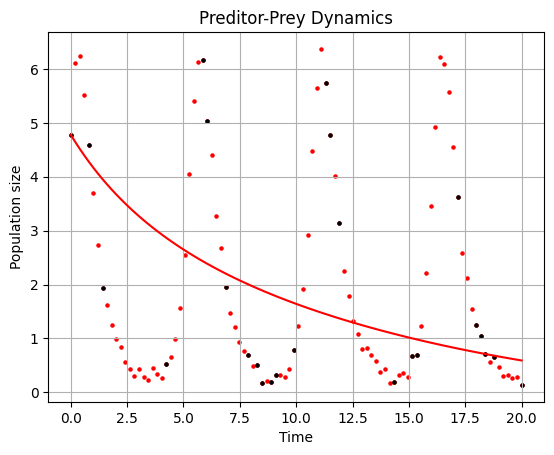

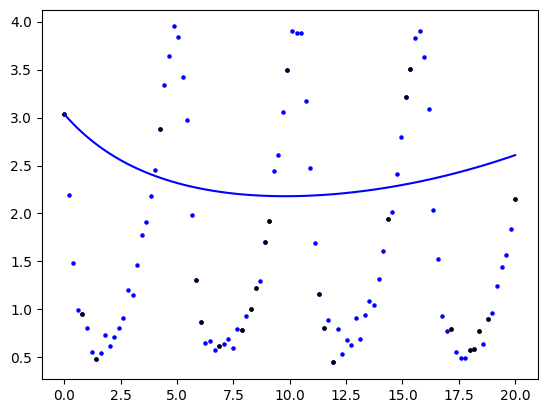

In [42]:
plot_lotka(df, minimised_75.x, df_subset_75)

C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 494.80513659457284
        x: [ 6.720e-01  3.651e-01 -8.935e-02 -1.707e-01]
      nit: 37
      jac: [-2.004e+03  4.851e+03  1.283e+04 -4.062e+03]
 hess_inv: [[ 7.216e-03  3.951e-03 -1.109e-03 -2.258e-03]
            [ 3.951e-03  2.171e-03 -6.106e-04 -1.237e-03]
            [-1.109e-03 -6.106e-04  1.736e-04  3.525e-04]
            [-2.258e-03 -1.237e-03  3.525e-04  7.224e-04]]
     nfev: 501
     njev: 98
100% of rows but from different subsets loss: 494.36166597804413


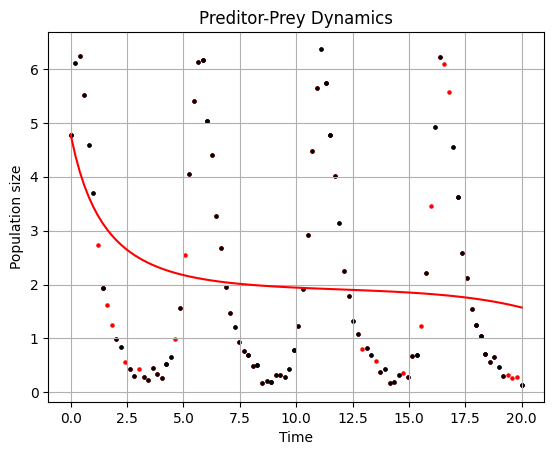

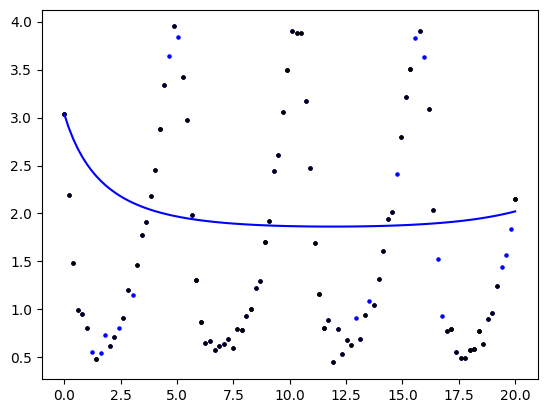

In [50]:
minimised_25_75 = minimise_loss_function_res(df_subset_25_75)
print(minimised_25_75)

plot_lotka(df, minimised_25_75.x, df_subset_25_75)


In [53]:
print(f"0% random removed points, loss: {minimised_original.fun}")
print(f"25% random removed points, loss: {loss_function_res(minimised_25.x, df)}")
print(f"50% random removed points, loss: {loss_function_res(minimised_50.x, df)}")
print(f"75% random removed points, loss: {loss_function_res(minimised_75.x, df)}")
print(f"Same amount of points but from different time series, loss: {loss_function_res(minimised_25_75.x, df)}")

0% random removed points, loss: 456.0418711258587
25% random removed points, loss: 747.9819204249422
50% random removed points, loss: 955.2625409846428
75% random removed points, loss: 614.1550391110002
Same amount of points but from different time series, loss: 494.36166597804413


## Remove specific points

In [60]:
import pandas as pd
def remove_last(df, percentage):
    index_to_keep = int(len(df) * percentage)
    return df.iloc[:index_to_keep]

df_subset_50first = remove_last(df, 0.5)
df_subset_90first = remove_last(df, 0.9)


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 193.3980182179261
        x: [ 6.075e-01  5.796e-01 -4.731e-01 -9.304e-01]
      nit: 33
      jac: [ 1.029e+03 -1.951e+03 -2.782e+03  8.825e+02]
 hess_inv: [[ 2.238e-02  3.045e-02 -3.737e-02 -7.685e-02]
            [ 3.045e-02  4.147e-02 -5.092e-02 -1.047e-01]
            [-3.737e-02 -5.092e-02  6.256e-02  1.287e-01]
            [-7.685e-02 -1.047e-01  1.287e-01  2.646e-01]]
     nfev: 509
     njev: 99


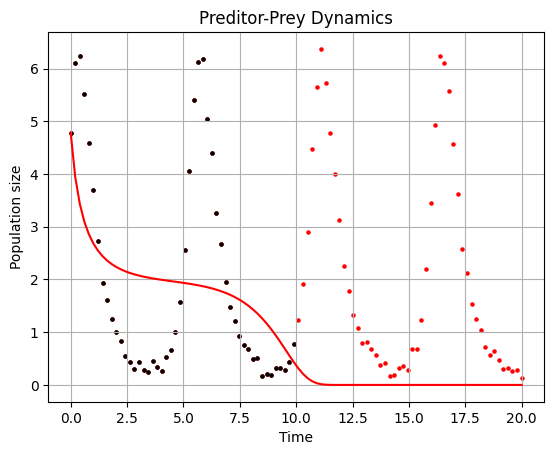

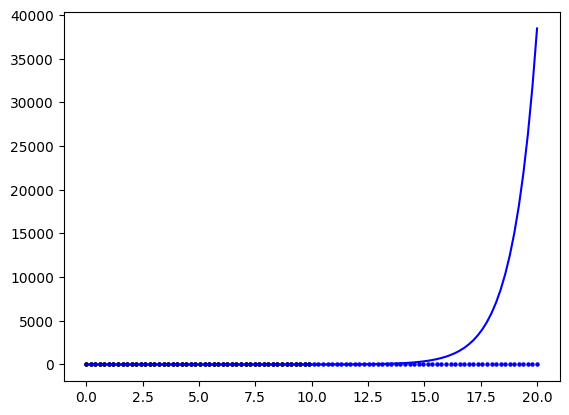

Removed last 50% of rows, loss: 4719351462.673521


In [61]:
minimised_50first = minimise_loss_function_res(df_subset_50first)
print(minimised_50first)

plot_lotka(df, minimised_50first.x, df_subset_50first)

print(f"Removed last 50% of rows, loss: {loss_function_res(minimised_50first.x, df)}")

C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 453.11946808549675
        x: [ 5.092e-01  3.673e-01 -1.785e-01 -3.332e-01]
      nit: 37
      jac: [ 3.834e+04 -8.069e+04 -1.425e+05  4.593e+04]
 hess_inv: [[ 1.542e-03  1.472e-03 -1.416e-03 -3.097e-03]
            [ 1.472e-03  1.407e-03 -1.355e-03 -2.962e-03]
            [-1.416e-03 -1.355e-03  1.305e-03  2.854e-03]
            [-3.097e-03 -2.962e-03  2.854e-03  6.243e-03]]
     nfev: 524
     njev: 101


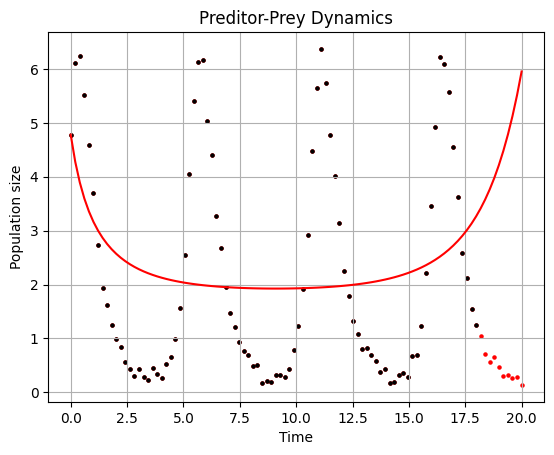

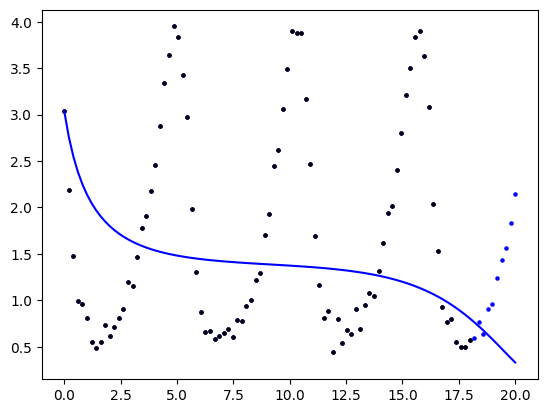

Removed last 50% of rows, loss: 632.8499601984598


In [63]:
minimised_90first = minimise_loss_function_res(df_subset_90first)
print(minimised_90first)

plot_lotka(df, minimised_90first.x, df_subset_90first)

print(f"Removed last 10% of rows, loss: {loss_function_res(minimised_90first.x, df)}")

In [64]:
print(f"0% random removed points, loss: {minimised_original.fun}")
print(f"25% random removed points, loss: {loss_function_res(minimised_25.x, df)}")
print(f"50% random removed points, loss: {loss_function_res(minimised_50.x, df)}")
print(f"75% random removed points, loss: {loss_function_res(minimised_75.x, df)}")
print(f"Same amount of points but from different time series, loss: {loss_function_res(minimised_25_75.x, df)}")
print(f"Removed last 10% of rows, loss: {loss_function_res(minimised_90first.x, df)}")
print(f"Removed last 50% of rows, loss: {loss_function_res(minimised_50first.x, df)}")

0% random removed points, loss: 456.0418711258587
25% random removed points, loss: 747.9819204249422
50% random removed points, loss: 955.2625409846428
75% random removed points, loss: 614.1550391110002
Same amount of points but from different time series, loss: 494.36166597804413
Removed last 10% of rows, loss: 632.8499601984598
Removed last 50% of rows, loss: 4719351462.673521
